# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Пилюгин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [4]:
def foo(size, n_batches):
    return np.random.randint(n_batches, size=size)
def batches(size):
    return np.array(range(0,size))

def count(y, n_batches):
    size = len(y)
    for i in range(0,n_batches):
        print(np.sum(y == i) / (size+0.0), " - ", i)
n_batches = 15
batches(n_batches)[0:9]
for i,j in np.array_split(a,2), np.array_split(a,2):
    print i,j
np.c_[a, np.ones(5)]
# y = foo(100, n_batches)
# count(y, n_batches)

[[1 2]
 [3 4]
 [5 6]] [[7 8]
 [8 9]]
[[1 2]
 [3 4]
 [5 6]] [[7 8]
 [8 9]]


array([[ 1.,  2.,  1.],
       [ 3.,  4.,  1.],
       [ 5.,  6.,  1.],
       [ 7.,  8.,  1.],
       [ 8.,  9.,  1.]])

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, n_batches = 50):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.n_batches = n_batches
    
    def grad(self, mini_batch_x, mini_batch_y):
        # ∇J(θ)=∑x(i)(h(-x(i).dot(θ))−y(i)) + C/m * theta, 
        # кроме j=0
        m = mini_batch_x.shape[0]
        l2 = self.C * self.theta #np.zeros(mini_batch_x.shape[1])#
        result = 1.0/m*((self.sigm(mini_batch_x) - mini_batch_y).dot(mini_batch_x) + l2)
        result[0] = result[0] - l2[0]/m
        return result
                
    def sigm(self, X):
        # 1/(1+exp(−θ.dot(x)))
        return (1.0/(1 + np.exp(-X.dot(self.theta))))
    
    def cost_function(self, X, y):
        # J(θ)=−1/m*∑(y(i)log(hθ(x(i)))+(1−y(i))log(1−hθ(x(i)))) + C/2m * ∑(θ_i)^2
        h_theta = self.sigm(X)
        m = X.shape[0]
        return -1.0/m*np.sum(np.log(h_theta).dot(y) + (np.log(1-h_theta)).dot(1-y)) + self.C/(2*m+0.0)*(self.theta.dot(self.theta))
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        n_samples = X.shape[0]
        n_features = X.shape[1]
        alpha = self.alpha
        self.theta = np.zeros(n_features+1)
        X = np.c_[np.ones(n_samples), X]
        # Для отладки: значения ошибок
        self.costs = []
        for n_epoch in range(self.max_epoch):
            # Выводим ошибку
            print "epoch ", n_epoch, ":  ", self.cost_function(X, y)
            self.costs.append(self.cost_function(X, y))
            # Запоминаем состояние генератора, чтобы перемешать совместно
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(y)
            # Делим на батчи 
            mini_batches_x = np.array_split(X, n_batches)
            mini_batches_y = np.array_split(y, n_batches)
            # Идем градиентным спуском по батчам
            for i in range(n_batches):    
                self.theta = self.theta - alpha * self.grad(mini_batches_x[i], mini_batches_y[i])
            # После каждой эпохи уменьшаем скорость, начиная с уменьшения в 2 раза
            alpha = self.alpha / (n_epoch+2)
        return self
    
    def errors(self):
        return self.costs
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        return (self.sigm(X) > 0.5).astype(int)
    
    def coef(self):
        return self.theta
             
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        return self.sigm(X)

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

array([ 1.,  1.,  1.,  1.,  1.])

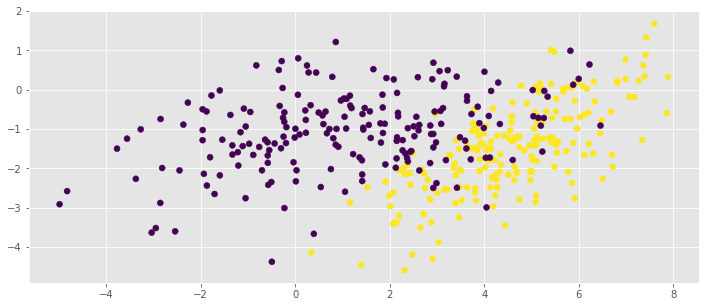

In [66]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
y1=y.copy()

plt.scatter(X[:,0], X[:,1], c=y)
y[:5]

In [67]:
model = MySGDClassifier(C=1, n_batches = 2, max_epoch = 25, alpha=0.8)
model.fit(X, y)
y = y1

epoch  0 :   0.69314718056
epoch  1 :   0.46106608147
epoch  2 :   0.417871977919
epoch  3 :   0.401936221937
epoch  4 :   0.392107453903
epoch  5 :   0.387690551314
epoch  6 :   0.383346973801
epoch  7 :   0.378677309511
epoch  8 :   0.375434225019
epoch  9 :   0.373358483869
epoch  10 :   0.371668203432
epoch  11 :   0.369598986716
epoch  12 :   0.370309230413
epoch  13 :   0.366737266834
epoch  14 :   0.365665506429
epoch  15 :   0.364987537659
epoch  16 :   0.363603922592
epoch  17 :   0.362950585985
epoch  18 :   0.363301206215
epoch  19 :   0.361327435548
epoch  20 :   0.360463019764
epoch  21 :   0.359814896616
epoch  22 :   0.359344942152
epoch  23 :   0.358694598205
epoch  24 :   0.358228480834


array([-2.79214456,  0.72221187, -0.59210197])

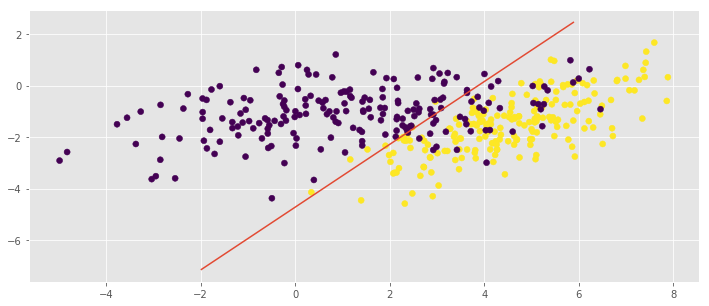

In [68]:
x_line = np.linspace(X[:,0].min()+3,X[:,0].max()-2,100)
coeffs = model.coef()
y_line = (coeffs[0]+coeffs[1]*x_line)/(-coeffs[2])
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_line, y_line)
coeffs

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

array([ 1.,  1.,  1.,  1.,  1.])

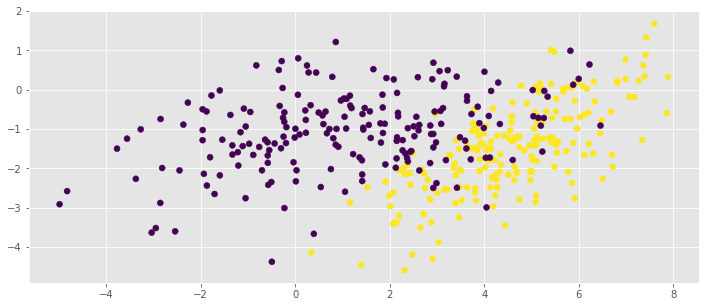

In [89]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
y1=y.copy()
y2=y.copy()
y3=y.copy()
plt.scatter(X[:,0], X[:,1], c=y)
y[:5]

epoch  0 :   0.69314718056
epoch  1 :   0.559939595344
epoch  2 :   0.545789442587
epoch  3 :   0.537462044789
epoch  4 :   0.531898888835
epoch  5 :   0.52758795001
epoch  6 :   0.524178170249
epoch  7 :   0.52130739013
epoch  8 :   0.518861673062
epoch  9 :   0.516735143103


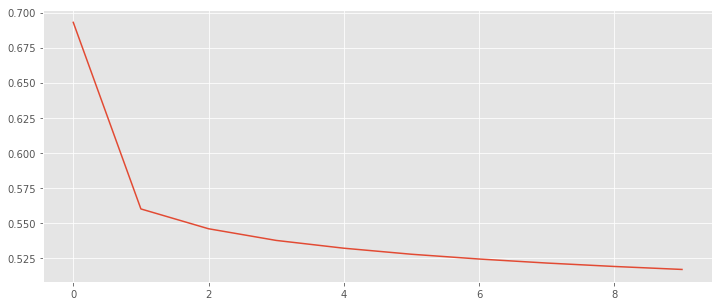

In [90]:
alpha = 0.1
model = MySGDClassifier(C=1, n_batches = 2, max_epoch = 10, alpha=alpha)
model.fit(X, y)
plt.figure()
plt.plot(range(10), model.errors())

epoch  0 :   0.69314718056
epoch  1 :   0.536103052298
epoch  2 :   0.519590928171
epoch  3 :   0.502687553305
epoch  4 :   0.494192529284
epoch  5 :   0.488339962611
epoch  6 :   0.483517084939
epoch  7 :   0.479589377723
epoch  8 :   0.476296341207
epoch  9 :   0.473521074269


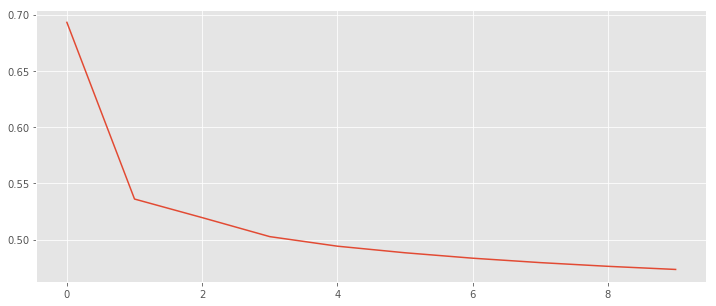

In [91]:
alpha = 0.2
model = MySGDClassifier(C=1, n_batches = 2, max_epoch = 10, alpha=alpha)
model.fit(X, y1)
plt.figure()
plt.plot(range(10), model.errors())

epoch  0 :   0.69314718056
epoch  1 :   0.492279395082
epoch  2 :   0.418945108874
epoch  3 :   0.416057308517
epoch  4 :   0.399111596351
epoch  5 :   0.386722729384
epoch  6 :   0.383571402227
epoch  7 :   0.37796165351
epoch  8 :   0.37691205291
epoch  9 :   0.380086337769
epoch  10 :   0.372461784251
epoch  11 :   0.370250410625
epoch  12 :   0.368598866001
epoch  13 :   0.366527598917
epoch  14 :   0.366763639981
epoch  15 :   0.365987028898
epoch  16 :   0.363733834384
epoch  17 :   0.362597414083
epoch  18 :   0.361896014923
epoch  19 :   0.361238726703
epoch  20 :   0.36083624207
epoch  21 :   0.360030289233
epoch  22 :   0.359437812742
epoch  23 :   0.358960005054
epoch  24 :   0.358159535389


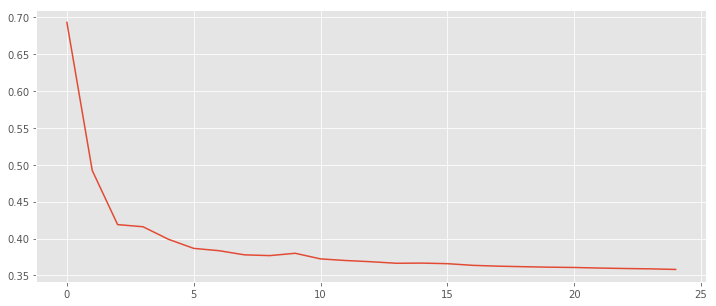

In [92]:
alpha = 0.8
model = MySGDClassifier(C=1, n_batches = 2, max_epoch = 25, alpha=alpha)
model.fit(X, y2)
plt.figure()
plt.plot(range(25), model.errors())

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [ ]:
## Youd Code Here

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here